# DATA

In [74]:
# @title import

from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import pickle
import json
import numpy as np
import time
import cv2
import sys
import xml.etree.ElementTree as ET
import os
from os import makedirs, listdir
from os.path import join, abspath, isfile, isdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import PIL
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
from keras.preprocessing.image import img_to_array, load_img
from keras import backend as K
from keras import regularizers
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Concatenate, LSTM, ConvLSTM2D, Dense, Flatten, Input, RepeatVector
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# @title data_preparation

class PIE(object):
    def __init__(self, regen_database=False, data_path=''):
        """ Class constructor
            :param regen_database: Whether generate the database or not
            :param data_path: The path to wh """
        self._name = 'pie'
        self._image_ext = '.png'
        self._regen_database = regen_database
        # Paths
        self._pie_path = data_path if data_path else self._get_default_path()
        assert isdir(self._pie_path), \
            'pie path does not exist: {}'.format(self._pie_path)
        self._annotation_path = join(self._pie_path, 'annotations')
        self._annotation_attributes_path = join(self._pie_path, 'annotations_attributes')
        self._annotation_vehicle_path = join(self._pie_path, 'annotations_vehicle')
        self._clips_path = join(self._pie_path, 'PIE_clips')
        self._images_path = join(self._pie_path, 'images')

    # Path generators
    @property
    def cache_path(self):
        """ Generates a path to save cache files """
        cache_path = abspath(join(self._pie_path, 'data_cache'))
        if not isdir(cache_path):
            makedirs(cache_path)
        return cache_path
    def _get_default_path(self):
        """ Returns the default path where pie is expected to be installed. """
        return 'data/pie'
    def _get_image_set_ids(self, image_set):
        """ Returns default image set ids
                :param image_set: Image set split
                :return: Set ids of the image set  """

        image_set_nums = {'train': ['set01'],
                          'val': ['set02'],
                          'test': ['set03'],
                          'all': ['set01', 'set02', 'set03']}

        return image_set_nums[image_set]


    def _get_image_path(self, sid, vid, fid):
        """ Generates and returns the image path given ids
              :param sid: Set id
              :param vid: Video id
              :param fid: Frame id
              :return: Return the path to the given image """
        return join(self._images_path, sid, vid, '{:05d}.png'.format(fid))

    # Visual helpers
    def update_progress(self, progress):
        """ Creates a progress bar """
        barLength = 20
        status = ""
        if isinstance(progress, int):
            progress = float(progress)
        block = int(round(barLength * progress))
        text = "\r[{}] {:0.2f}% {}".format("#" * block + "-" * (barLength - block), progress * 100, status)
        sys.stdout.write(text)
        sys.stdout.flush()

    def _print_dict(self, dic):
        """ Prints a dictionary, one key-value pair per line """
        for k, v in dic.items():
            print('%s: %s' % (str(k), str(v)))

    # Data processing helpers
    def _get_width(self):
        """ Returns image width """
        return 1920
    def _get_height(self):
        """ Returns image height """
        return 1080
    def _get_dim(self):
        """ Returns the image dimensions """
        return 1920, 1080

    # Image processing helpers
    def get_annotated_frame_numbers(self, set_id):
        """ Generates and returns a dictionary of videos and annotated frames for each video in the give set
        :param set_id: Set to generate annotated frames
        :return: A dictionary of form : {<video_id>: [<number_of_frames>,<annotated_frame_id_0>,... <annotated_frame_id_n>]} """
        print("Generating annotated frame numbers for", set_id)
        annotated_frames_file = join(self._pie_path, "annotations", set_id, set_id + '_annotated_frames.csv')
        # If the file exists, load from the file
        if isfile(annotated_frames_file):
            with open(annotated_frames_file, 'rt') as f:
                annotated_frames = {x.split(',')[0]:
                                        [int(fr) for fr in x.split(',')[1:]] for x in f.readlines()}
            return annotated_frames
        else:
            # Generate annotated frame ids for each video
            annotated_frames = {v.split('_annt.xml')[0]: [] for v in sorted(listdir(join(self._annotation_path,
                                                                                         set_id))) if
                                v.endswith("annt.xml")}
            for vid, annot_frames in sorted(annotated_frames.items()):
                _frames = []
                path_to_file = join(self._annotation_path, set_id, vid + '_annt.xml')
                tree = ET.parse(path_to_file)
                tracks = tree.findall('./track')
                for t in tracks:
                    if t.get('label') != 'pedestrian':
                        continue
                    boxes = t.findall('./box')
                    for b in boxes:
                        # Exclude the annotations that are outside of the frame
                        if int(b.get('outside')) == 1:
                            continue
                        _frames.append(int(b.get('frame')))
                _frames = sorted(list(set(_frames)))
                annot_frames.append(len(_frames))
                annot_frames.extend(_frames)

            with open(annotated_frames_file, 'wt') as fid:
                for vid, annot_frames in sorted(annotated_frames.items()):
                    fid.write(vid)
                    for fr in annot_frames:
                        fid.write("," + str(fr))
                    fid.write('\n')
        return annotated_frames

    def get_frame_numbers(self, set_id):
        """ Generates and returns a dictionary of videos and  frames for each video in the give set
        :param set_id: Set to generate annotated frames
        :return: A dictionary of form: {<video_id>: [<number_of_frames>,<frame_id_0>,... <frame_id_n>]} """
        print("Generating frame numbers for", set_id)
        frame_ids = {v.split('_annt.xml')[0]: [] for v in sorted(listdir(join(self._annotation_path,
                                                                              set_id))) if
                     v.endswith("annt.xml")}
        for vid, frames in sorted(frame_ids.items()):
            path_to_file = join(self._annotation_path, set_id, vid + '_annt.xml')
            tree = ET.parse(path_to_file)
            num_frames = int(tree.find("./meta/task/size").text)
            frames.extend([i for i in range(num_frames)])
            frames.insert(0, num_frames)
        return frame_ids

    def extract_and_save_images(self, extract_frame_type='annotated'):
        """ Extracts images from clips and saves on hard drive
        :param extract_frame_type: Whether to extract 'all' frames or only the ones that are 'annotated' """
        set_folders = [f for f in sorted(listdir(self._clips_path))]
        for set_id in set_folders:
            print('Extracting frames from', set_id)
            set_folder_path = join(self._clips_path, set_id)
            if extract_frame_type == 'annotated':
                extract_frames = self.get_annotated_frame_numbers(set_id)
            else:
                extract_frames = self.get_frame_numbers(set_id)
            set_images_path = join(self._pie_path, "images", set_id)
            for vid, frames in sorted(extract_frames.items()):
                print(vid)
                video_images_path = join(set_images_path, vid)
                num_frames = frames[0]
                frames_list = frames[1:]
                if not isdir(video_images_path):
                    makedirs(video_images_path)
                vidcap = cv2.VideoCapture(join(set_folder_path, vid + '.mp4'))
                success, image = vidcap.read()
                frame_num = 0
                img_count = 0
                if not success:
                    print('Failed to open the video {}'.format(vid))
                while success:
                    if frame_num in frames_list:
                        self.update_progress(img_count / num_frames)
                        img_count += 1
                        if not isfile(join(video_images_path, "%05.f.png") % frame_num):
                            cv2.imwrite(join(video_images_path, "%05.f.png") % frame_num, image)
                    success, image = vidcap.read()
                    frame_num += 1
                if num_frames != img_count:
                    print('num images don\'t match {}/{}'.format(num_frames, img_count))
                print('\n')

    # Annotation processing helpers
    def _map_text_to_scalar(self, label_type, value):
        """ Maps a text label in XML file to scalars
        :param label_type: The label type
        :param value: The text to be mapped
        :return: The scalar value """

        map_dic = {'occlusion': {'none': 0, 'part': 1, 'full': 2},
                   'action': {'standing': 0, 'walking': 1},
                   'look': {'not-looking': 0, 'looking': 1},
                   'gesture': {'__undefined__': 0, 'hand_ack': 1, 'hand_yield': 2,
                               'hand_rightofway': 3, 'nod': 4, 'other': 5},
                   'cross': {'not-crossing': 0, 'crossing': 1, 'crossing-irrelevant': -1},
                   'crossing': {'not-crossing': 0, 'crossing': 1, 'irrelevant': -1},
                   'age': {'child': 0, 'young': 1, 'adult': 2, 'senior': 3},
                   'designated': {'ND': 0, 'D': 1},
                   'gender': {'n/a': 0, 'female': 1, 'male': 2},
                   'intersection': {'midblock': 0, 'T': 1, 'T-left': 2, 'T-right': 3, 'four-way': 4},
                   'motion_direction': {'n/a': 0, 'LAT': 1, 'LONG': 2},
                   'traffic_direction': {'OW': 0, 'TW': 1},
                   'signalized': {'n/a': 0, 'C': 1, 'S': 2, 'CS': 3},
                   'vehicle': {'car': 0, 'truck': 1, 'bus': 2, 'train': 3, 'bicycle': 4, 'bike': 5},
                   'sign': {'ped_blue': 0, 'ped_yellow': 1, 'ped_white': 2, 'ped_text': 3, 'stop_sign': 4,
                            'bus_stop': 5, 'train_stop': 6, 'construction': 7, 'other': 8},
                   'traffic_light': {'regular': 0, 'transit': 1, 'pedestrian': 2},
                   'state': {'__undefined__': 0, 'red': 1, 'yellow': 2, 'green': 3}}

        return map_dic[label_type][value]

    def _map_scalar_to_text(self, label_type, value):
        """    Maps a scalar value to a text label
        :param label_type: The label type
        :param value: The scalar to be mapped
        :return: The text label   """

        map_dic = {'occlusion': {0: 'none', 1: 'part', 2: 'full'},
                   'action': {0: 'standing', 1: 'walking'},
                   'look': {0: 'not-looking', 1: 'looking'},
                   'hand_gesture': {0: '__undefined__', 1: 'hand_ack',
                                    2: 'hand_yield', 3: 'hand_rightofway',
                                    4: 'nod', 5: 'other'},
                   'cross': {0: 'not-crossing', 1: 'crossing', -1: 'crossing-irrelevant'},
                   'crossing': {0: 'not-crossing', 1: 'crossing', -1: 'irrelevant'},
                   'age': {0: 'child', 1: 'young', 2: 'adult', 3: 'senior'},
                   'designated': {0: 'ND', 1: 'D'},
                   'gender': {0: 'n/a', 1: 'female', 2: 'male'},
                   'intersection': {0: 'midblock', 1: 'T', 2: 'T-left', 3: 'T-right', 4: 'four-way'},
                   'motion_direction': {0: 'n/a', 1: 'LAT', 2: 'LONG'},
                   'traffic_direction': {0: 'OW', 1: 'TW'},
                   'signalized': {0: 'n/a', 1: 'C', 2: 'S', 3: 'CS'},
                   'vehicle': {0: 'car', 1: 'truck', 2: 'bus', 3: 'train', 4: 'bicycle', 5: 'bike'},
                   'sign': {0: 'ped_blue', 1: 'ped_yellow', 2: 'ped_white', 3: 'ped_text', 4: 'stop_sign',
                            5: 'bus_stop', 6: 'train_stop', 7: 'construction', 8: 'other'},
                   'traffic_light': {0: 'regular', 1: 'transit', 2: 'pedestrian'},
                   'state': {0: '__undefined__', 1: 'red', 2: 'yellow', 3: 'green'}}

        return map_dic[label_type][value]

    def _get_annotations(self, setid, vid):
        """ Generates a dictionary of annotations by parsing the video XML file
        :param setid: The set id
        :param vid: The video id
        :return: A dictionary of annotations """
        path_to_file = join(self._annotation_path, setid, vid + '_annt.xml')
        print(path_to_file)
        tree = ET.parse(path_to_file)
        ped_annt = 'ped_annotations'
        traffic_annt = 'traffic_annotations'
        annotations = {}
        annotations['num_frames'] = int(tree.find("./meta/task/size").text)
        annotations['width'] = int(tree.find("./meta/task/original_size/width").text)
        annotations['height'] = int(tree.find("./meta/task/original_size/height").text)
        annotations[ped_annt] = {}
        annotations[traffic_annt] = {}
        tracks = tree.findall('./track')
        for t in tracks:
            boxes = t.findall('./box')
            obj_label = t.get('label')
            obj_id = boxes[0].find('./attribute[@name=\"id\"]').text
            if obj_label == 'pedestrian':
                annotations[ped_annt][obj_id] = {'frames': [], 'bbox': [], 'occlusion': []}
                annotations[ped_annt][obj_id]['behavior'] = {'gesture': [], 'look': [], 'action': [], 'cross': []}
                for b in boxes:
                    # Exclude the annotations that are outside of the frame
                    if int(b.get('outside')) == 1:
                        continue
                    annotations[ped_annt][obj_id]['bbox'].append(
                        [float(b.get('xtl')), float(b.get('ytl')),
                         float(b.get('xbr')), float(b.get('ybr'))])
                    occ = self._map_text_to_scalar('occlusion', b.find('./attribute[@name=\"occlusion\"]').text)
                    annotations[ped_annt][obj_id]['occlusion'].append(occ)
                    annotations[ped_annt][obj_id]['frames'].append(int(b.get('frame')))
                    for beh in annotations['ped_annotations'][obj_id]['behavior']:
                        # Read behavior tags for each frame and add to the database
                        annotations[ped_annt][obj_id]['behavior'][beh].append(
                            self._map_text_to_scalar(beh, b.find('./attribute[@name=\"' + beh + '\"]').text))
            else:
                obj_type = boxes[0].find('./attribute[@name=\"type\"]')
                if obj_type is not None:
                    obj_type = self._map_text_to_scalar(obj_label, boxes[0].find('./attribute[@name=\"type\"]').text)
                annotations[traffic_annt][obj_id] = {'frames': [], 'bbox': [], 'occlusion': [],
                                                     'obj_class': obj_label,
                                                     'obj_type': obj_type,
                                                     'state': []}
                for b in boxes:
                    # Exclude the annotations that are outside of the frame
                    if int(b.get('outside')) == 1:
                        continue
                    annotations[traffic_annt][obj_id]['bbox'].append(
                        [float(b.get('xtl')), float(b.get('ytl')),
                         float(b.get('xbr')), float(b.get('ybr'))])
                    annotations[traffic_annt][obj_id]['occlusion'].append(int(b.get('occluded')))
                    annotations[traffic_annt][obj_id]['frames'].append(int(b.get('frame')))
                    if obj_label == 'traffic_light':
                        annotations[traffic_annt][obj_id]['state'].append(self._map_text_to_scalar('state', b.find('./attribute[@name=\"state\"]').text))
        return annotations

    def _get_ped_attributes(self, setid, vid):
        """  Generates a dictionary of attributes by parsing the video XML file
        :param setid: The set id
        :param vid: The video id
        :return: A dictionary of attributes  """
        path_to_file = join(self._annotation_attributes_path, setid, vid + '_attributes.xml')
        tree = ET.parse(path_to_file)
        attributes = {}
        pedestrians = tree.findall("./pedestrian")
        for p in pedestrians:
            ped_id = p.get('id')
            attributes[ped_id] = {}
            for k, v in p.items():
                if 'id' in k:
                    continue
                try:
                    if k == 'intention_prob':
                        attributes[ped_id][k] = float(v)
                    else:
                        attributes[ped_id][k] = int(v)
                except ValueError:
                    attributes[ped_id][k] = self._map_text_to_scalar(k, v)
        return attributes

    def _get_vehicle_attributes(self, setid, vid):
        """  Generates a dictionary of vehicle attributes by parsing the video XML file
        :param setid: The set id
        :param vid: The video id
        :return: A dictionary of vehicle attributes (obd sensor recording)   """
        path_to_file = join(self._annotation_vehicle_path, setid, vid + '_obd.xml')
        tree = ET.parse(path_to_file)
        veh_attributes = {}
        frames = tree.findall("./frame")
        for f in frames:
            dict_vals = {k: float(v) for k, v in f.attrib.items() if k != 'id'}
            veh_attributes[int(f.get('id'))] = dict_vals
        return veh_attributes

    def generate_database(self):
        """    Generates and saves a database of the pie dataset by integrating all annotations
        Dictionary structure:
        'set_id'(str): {
            'vid_id'(str): {
                'num_frames': int
                'width': int
                'height': int
                'traffic_annotations'(str): {
                    'obj_id'(str): {
                        'frames': list(int)
                        'occlusion': list(int)
                        'bbox': list([x1, y1, x2, y2]) (float)
                        'obj_class': str,
                        'obj_type': str,    # only for traffic lights, vehicles, signs
                        'state': list(int)  # only for traffic lights
                'ped_annotations'(str): {
                    'ped_id'(str): {
                        'frames': list(int)
                        'occlusion': list(int)
                        'bbox': list([x1, y1, x2, y2]) (float)
                        'behavior'(str): {
                            'action': list(int)
                            'gesture': list(int)
                            'cross': list(int)
                            'look': list(int)
                        'attributes'(str): {
                             'age': int
                             'id': str
                             'num_lanes': int
                             'crossing': int
                             'gender': int
                             'crossing_point': int
                             'critical_point': int
                             'exp_start_point': int
                             'intersection': int
                             'designated': int
                             'signalized': int
                             'traffic_direction': int
                             'group_size': int
                             'motion_direction': int
                'vehicle_annotations'(str){
                    'frame_id'(int){'longitude': float
                          'yaw': float
                          'pitch': float
                          'roll': float
                          'OBD_speed': float
                          'GPS_speed': float
                          'latitude': float
                          'longitude': float
                          'heading_angle': float
                          'accX': float
                          'accY': float
                          'accZ: float
                          'gyroX': float
                          'gyroY': float
                          'gyroZ': float

        :return: A database dictionary  """
        print('---------------------------------------------------------')
        print("Generating database for pie")
        cache_file = join(self.cache_path, 'pie_database.pkl')
        if isfile(cache_file) and not self._regen_database:
            with open(cache_file, 'rb') as fid:
                try:
                    database = pickle.load(fid)
                except:
                    database = pickle.load(fid, encoding='bytes')
            print('pie annotations loaded from {}'.format(cache_file))
            return database
        # Path to the folder annotations
        set_ids = [f for f in sorted(listdir(self._annotation_path))]
        # Read the content of set folders
        database = {}
        for setid in set_ids:
            video_ids = [v.split('_annt.xml')[0] for v in sorted(listdir(join(self._annotation_path,
                                                                              setid))) if v.endswith("annt.xml")]
            database[setid] = {}
            for vid in video_ids:
                print('Getting annotations for %s, %s' % (setid, vid))
                database[setid][vid] = self._get_annotations(setid, vid)
                vid_attributes = self._get_ped_attributes(setid, vid)
                database[setid][vid]['vehicle_annotations'] = self._get_vehicle_attributes(setid, vid)
                for ped in database[setid][vid]['ped_annotations']:
                    database[setid][vid]['ped_annotations'][ped]['attributes'] = vid_attributes[ped]
        with open(cache_file, 'wb') as fid:
            pickle.dump(database, fid, pickle.HIGHEST_PROTOCOL)
        print('The database is written to {}'.format(cache_file))
        return database

    def get_data_stats(self):
        """ Generates statistics for the dataset """
        annotations = self.generate_database()
        set_count = len(annotations.keys())
        ped_count = 0
        ped_box_count = 0
        video_count = 0
        total_frames = 0
        age = {'child': 0, 'adult': 0, 'senior': 0}
        gender = {'male': 0, 'female': 0}
        signalized = {'n/a': 0, 'C': 0, 'S': 0, 'CS': 0}
        traffic_direction = {'OW': 0, 'TW': 0}
        intersection = {'midblock': 0, 'T': 0, 'T-right': 0, 'T-left': 0, 'four-way': 0}
        crossing = {'crossing': 0, 'not-crossing': 0, 'irrelevant': 0}
        traffic_obj_types = {'vehicle': {'car': 0, 'truck': 0, 'bus': 0, 'train': 0, 'bicycle': 0, 'bike': 0},
                             'sign': {'ped_blue': 0, 'ped_yellow': 0, 'ped_white': 0, 'ped_text': 0, 'stop_sign': 0,
                                      'bus_stop': 0, 'train_stop': 0, 'construction': 0, 'other': 0},
                             'traffic_light': {'regular': 0, 'transit': 0, 'pedestrian': 0},
                             'crosswalk': 0,
                             'transit_station': 0}
        traffic_box_count = {'vehicle': 0, 'traffic_light': 0, 'sign': 0, 'crosswalk': 0, 'transit_station': 0}
        for sid, vids in annotations.items():
            video_count += len(vids)
            for vid, annots in vids.items():
                total_frames += annots['num_frames']
                for trf_ids, trf_annots in annots['traffic_annotations'].items():
                    obj_class = trf_annots['obj_class']
                    traffic_box_count[obj_class] += len(trf_annots['frames'])
                    if obj_class in ['traffic_light', 'vehicle', 'sign']:
                        obj_type = trf_annots['obj_type']
                        traffic_obj_types[obj_class][self._map_scalar_to_text(obj_class, obj_type)] += 1
                    else:
                        traffic_obj_types[obj_class] += 1
                for ped_ids, ped_annots in annots['ped_annotations'].items():
                    ped_count += 1
                    ped_box_count += len(ped_annots['frames'])
                    age[self._map_scalar_to_text('age', ped_annots['attributes']['age'])] += 1
                    if self._map_scalar_to_text('crossing', ped_annots['attributes']['crossing']) == 'crossing':
                        crossing[self._map_scalar_to_text('crossing', ped_annots['attributes']['crossing'])] += 1
                    else:
                        if ped_annots['attributes']['intention_prob'] > 0.5:
                            crossing['not-crossing'] += 1
                        else:
                            crossing['irrelevant'] += 1
                    intersection[
                        self._map_scalar_to_text('intersection', ped_annots['attributes']['intersection'])] += 1
                    traffic_direction[self._map_scalar_to_text('traffic_direction',
                                                               ped_annots['attributes']['traffic_direction'])] += 1
                    signalized[self._map_scalar_to_text('signalized', ped_annots['attributes']['signalized'])] += 1
                    gender[self._map_scalar_to_text('gender', ped_annots['attributes']['gender'])] += 1

        print('---------------------------------------------------------')
        print("Number of sets: %d" % set_count)
        print("Number of videos: %d" % video_count)
        print("Number of annotated frames: %d" % total_frames)
        print("Number of pedestrians %d" % ped_count)
        print("age:\n", '\n '.join('{}: {}'.format(tag, cnt) for tag, cnt in sorted(age.items())))
        print("gender:\n", '\n '.join('{}: {}'.format(tag, cnt) for tag, cnt in sorted(gender.items())))
        print("signal:\n", '\n '.join('{}: {}'.format(tag, cnt) for tag, cnt in sorted(signalized.items())))
        print("traffic direction:\n",
              '\n '.join('{}: {}'.format(tag, cnt) for tag, cnt in sorted(traffic_direction.items())))
        print("crossing:\n", '\n '.join('{}: {}'.format(tag, cnt) for tag, cnt in sorted(crossing.items())))
        print("intersection:\n", '\n '.join('{}: {}'.format(tag, cnt) for tag, cnt in sorted(intersection.items())))
        print("Number of pedestrian bounding boxes: %d" % ped_box_count)
        print("Number of traffic objects")
        for trf_obj, values in sorted(traffic_obj_types.items()):
            if isinstance(values, dict):
                print(trf_obj + ':\n', '\n '.join('{}: {}'.format(k, v) for k, v in sorted(values.items())),
                      '\n total: ', sum(values.values()))
            else:
                print(trf_obj + ': %d' % values)
        print("Number of pedestrian bounding boxes:\n",
              '\n '.join('{}: {}'.format(tag, cnt) for tag, cnt in sorted(traffic_box_count.items())),
              '\n total: ', sum(traffic_box_count.values()))

    def balance_samples_count(self, seq_data, label_type, random_seed=1234):
        """   Balances the number of positive and negative samples by randomly sampling
        from the more represented samples. Only works for binary classes.
        :param seq_data: The sequence data to be balanced.
        :param label_type: The lable type based on which the balancing takes place.
        The label values must be binary, i.e. only 0, 1.
        :param random_seed: The seed for random number generator.
        :return: Balanced data sequence.   """
        for lbl in seq_data[label_type]:
            for i in lbl:
                if i[0] not in [0, 1]:
                    raise Exception("The label values used for balancing must be either 0 or 1")
        # balances the number of positive and negative samples
        print('---------------------------------------------------------')
        print("Balancing the number of positive and negative intention samples")
        gt_labels = [gt[0] for gt in seq_data[label_type]]
        num_pos_samples = np.count_nonzero(np.array(gt_labels))
        num_neg_samples = len(gt_labels) - num_pos_samples
        new_seq_data = {}
        # finds the indices of the samples with larger quantity
        if num_neg_samples == num_pos_samples:
            print('Positive and negative samples are already balanced')
            return seq_data
        else:
            print('Unbalanced: \t Positive: {} \t Negative: {}'.format(num_pos_samples, num_neg_samples))
            if num_neg_samples > num_pos_samples:
                rm_index = np.where(np.array(gt_labels) == 0)[0]
            else:
                rm_index = np.where(np.array(gt_labels) == 1)[0]

            # Calculate the difference of sample counts
            dif_samples = abs(num_neg_samples - num_pos_samples)
            # shuffle the indices
            np.random.seed(random_seed)
            np.random.shuffle(rm_index)
            # reduce the number of indices to the difference
            rm_index = rm_index[0:dif_samples]
            # update the data
            for k in seq_data:
                seq_data_k = seq_data[k]
                if not isinstance(seq_data[k], list):
                    new_seq_data[k] = seq_data[k]
                else:
                    new_seq_data[k] = [seq_data_k[i] for i in range(0, len(seq_data_k)) if i not in rm_index]

            new_gt_labels = [gt[0] for gt in new_seq_data[label_type]]
            num_pos_samples = np.count_nonzero(np.array(new_gt_labels))
            print('Balanced:\t Positive: %d  \t Negative: %d\n'
                  % (num_pos_samples, len(new_seq_data[label_type]) - num_pos_samples))
        return new_seq_data

    # Process pedestrian ids
    def _get_pedestrian_ids(self):
        """ Returns a list with all pedestrian ids """
        annotations = self.generate_database()
        pids = []
        for sid in sorted(annotations):
            for vid in sorted(annotations[sid]):
                pids.extend(annotations[sid][vid]['ped_annotations'].keys())
        return pids

    # Trajectory data generation
    def _get_data_ids(self, image_set, params):
        """ Generates set ids and ped ids (if needed) for processing
              :param image_set: Image-set to generate data
              :param params: Data generation params
              :return: Set and pedestrian ids    """
        _pids = None
        if params['data_split_type'] == 'default':
            set_ids = self._get_image_set_ids(image_set)
        else:
            set_ids = self._get_image_set_ids('all')
        if params['data_split_type'] == 'random':
            _pids = self._get_random_pedestrian_ids(image_set, **params['random_params'])
        elif params['data_split_type'] == 'kfold':
            _pids = self._get_kfold_pedestrian_ids(image_set, **params['kfold_params'])
        return set_ids, _pids

    def _squarify(self, bbox, ratio, img_width):
        """ Changes the ratio of bounding boxes to a fixed ratio
        :param bbox: Bounding box
        :param ratio: Ratio to be changed to
        :param img_width: Image width
        :return: Squarified boduning box """
        width = abs(bbox[0] - bbox[2])
        height = abs(bbox[1] - bbox[3])
        width_change = height * ratio - width
        bbox[0] = bbox[0] - width_change / 2
        bbox[2] = bbox[2] + width_change / 2
        if bbox[0] < 0:
            bbox[0] = 0

        # check whether the new bounding box goes beyond image boarders
        # If this is the case, the bounding box is shifted back
        if bbox[2] > img_width:
            bbox[0] = bbox[0] - bbox[2] + img_width
            bbox[2] = img_width
        return bbox

    def _height_check(self, height_rng, frame_ids, boxes, images, occlusion):
        """ Checks whether the bounding boxes are within a given height limit. If not, it
        will adjust the length of bounding boxes in data sequences accordingly
        :param height_rng: Height limit [lower, higher]
        :param frame_ids: List of frame ids
        :param boxes: List of bounding boxes
        :param images: List of images
        :param occlusion: List of occlusions
        :return: The adjusted data sequences """
        imgs, box, frames, occ = [], [], [], []
        for i, b in enumerate(boxes):
            bbox_height = abs(b[1] - b[3])
            if height_rng[0] <= bbox_height <= height_rng[1]:
                box.append(b)
                imgs.append(images[i])
                frames.append(frame_ids[i])
                occ.append(occlusion[i])
        return imgs, box, frames, occ

    def _get_center(self, box):
        """ Calculates the center coordinate of a bounding box
        :param box: Bounding box coordinates
        :return: The center coordinate """
        return [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]

    def generate_data_trajectory_sequence(self, image_set, **opts):
        """ Generates pedestrian tracks
        :param image_set: the split set to produce for. Options are train, test, val.
        :param opts:
        'fstride': Frequency of sampling from the data.
        'height_rng': The height range of pedestrians to use.
        'squarify_ratio': The width/height ratio of bounding boxes. A value between (0,1]. 0 the original ratio is used.
        'data_split_type': How to split the data. Options: 'default', predefined sets, 'random', randomly split the data, and 'kfold', k-fold data split (NOTE: only train/test splits)
        'seq_type': Sequence type to generate. Options: 'trajectory', generates tracks, 'crossing', generates tracks up to 'crossing_point', 'intention' generates tracks similar to human experiments
        'min_track_size': Min track length allowable.
        :return: Sequence data """

        params = {'fstride': 1,
                  'sample_type': 'all',
                  'height_rng': [0, float('inf')],
                  'squarify_ratio': 0,
                  'data_split_type': 'default',  # kfold, random, default
                  'seq_type': 'intention',
                  'min_track_size': 3}

        for i in opts.keys():
            params[i] = opts[i]

        print('---------------------------------------------------------')
        print("Generating trajectory sequence data")
        self._print_dict(params)
        annot_database = self.generate_database()
        if params['seq_type'] == 'trajectory':
            sequence_data = self._get_trajectories(image_set, annot_database, **params)
        elif params['seq_type'] == 'crossing':
            sequence_data = self._get_crossing(image_set, annot_database, **params)
        elif params['seq_type'] == 'intention':
            sequence_data = self._get_intention(image_set, annot_database, **params)

        return sequence_data

    def _get_trajectories(self, image_set, annotations, **params):
        """  Generates trajectory data.
        :param image_set: Data split to use
        :param annotations: Annotations database
        :param params: Parameters to generate data
        :return: A dictionary of trajectories """
        print('---------------------------------------------------------')
        print("Generating trajectory data")
        num_pedestrians = 0
        seq_stride = params['fstride']
        sq_ratio = params['squarify_ratio']
        height_rng = params['height_rng']
        image_seq, pids_seq = [], []
        box_seq, center_seq, occ_seq = [], [], []
        intent_seq = []
        obds_seq, gpss_seq, head_ang_seq, gpsc_seq, yrp_seq = [], [], [], [], []
        set_ids, _pids = self._get_data_ids(image_set, params)
        for sid in set_ids:
            for vid in sorted(annotations[sid]):
                img_width = annotations[sid][vid]['width']
                pid_annots = annotations[sid][vid]['ped_annotations']
                vid_annots = annotations[sid][vid]['vehicle_annotations']
                for pid in sorted(pid_annots):
                    if params['data_split_type'] != 'default' and pid not in _pids:
                        continue
                    num_pedestrians += 1
                    frame_ids = pid_annots[pid]['frames']
                    boxes = pid_annots[pid]['bbox']
                    images = [self._get_image_path(sid, vid, f) for f in frame_ids]
                    occlusions = pid_annots[pid]['occlusion']
                    if height_rng[0] > 0 or height_rng[1] < float('inf'):
                        images, boxes, frame_ids, occlusions = self._height_check(height_rng, frame_ids, boxes, images, occlusions)
                    if len(boxes) / seq_stride < params['min_track_size']:
                        continue
                    if sq_ratio:
                        boxes = [self._squarify(b, sq_ratio, img_width) for b in boxes]
                    image_seq.append(images[::seq_stride])
                    box_seq.append(boxes[::seq_stride])
                    center_seq.append([self._get_center(b) for b in boxes][::seq_stride])
                    occ_seq.append(occlusions[::seq_stride])
                    ped_ids = [[pid]] * len(boxes)
                    pids_seq.append(ped_ids[::seq_stride])
                    intent = [[pid_annots[pid]['attributes']['intention_prob']]] * len(boxes)
                    intent_seq.append(intent[::seq_stride])
                    gpsc_seq.append([(vid_annots[i]['latitude'], vid_annots[i]['longitude'])
                                     for i in frame_ids][::seq_stride])
                    obds_seq.append([[vid_annots[i]['OBD_speed']] for i in frame_ids][::seq_stride])
                    gpss_seq.append([[vid_annots[i]['GPS_speed']] for i in frame_ids][::seq_stride])
                    head_ang_seq.append([[vid_annots[i]['heading_angle']] for i in frame_ids][::seq_stride])
                    yrp_seq.append([(vid_annots[i]['yaw'], vid_annots[i]['roll'], vid_annots[i]['pitch'])
                                    for i in frame_ids][::seq_stride])

        print('Subset: %s' % image_set)
        print('Number of pedestrians: %d ' % num_pedestrians)
        print('Total number of samples: %d ' % len(image_seq))
        return {'image': image_seq,
                'pid': pids_seq,
                'bbox': box_seq,
                'center': center_seq,
                'occlusion': occ_seq,
                'obd_speed': obds_seq,
                'gps_speed': gpss_seq,
                'heading_angle': head_ang_seq,
                'gps_coord': gpsc_seq,
                'yrp': yrp_seq,
                'intention_prob': intent_seq}

    def _get_intention(self, image_set, annotations, **params):
        """   Generates intention data.
                  :param image_set: Data split to use
                  :param annotations: Annotations database
                  :param params: Parameters to generate data (see generade_database)
                  :return: A dictionary of trajectories  """
        print('---------------------------------------------------------')
        print("Generating intention data")
        num_pedestrians = 0
        seq_stride = params['fstride']
        sq_ratio = params['squarify_ratio']
        height_rng = params['height_rng']
        intention_prob, intention_binary = [], []
        image_seq, pids_seq = [], []
        box_seq, center_seq, occ_seq = [], [], []
        set_ids, _pids = self._get_data_ids(image_set, params)
        for sid in set_ids:
            for vid in sorted(annotations[sid]):
                img_width = annotations[sid][vid]['width']
                pid_annots = annotations[sid][vid]['ped_annotations']
                for pid in sorted(pid_annots):
                    if params['data_split_type'] != 'default' and pid not in _pids:
                        continue
                    num_pedestrians += 1
                    exp_start_frame = pid_annots[pid]['attributes']['exp_start_point']
                    critical_frame = pid_annots[pid]['attributes']['critical_point']
                    frames = pid_annots[pid]['frames']
                    start_idx = frames.index(exp_start_frame)
                    end_idx = frames.index(critical_frame)
                    boxes = pid_annots[pid]['bbox'][start_idx:end_idx + 1]
                    frame_ids = frames[start_idx:end_idx + 1]
                    images = [self._get_image_path(sid, vid, f) for f in frame_ids]
                    occlusions = pid_annots[pid]['occlusion'][start_idx:end_idx + 1]
                    if height_rng[0] > 0 or height_rng[1] < float('inf'):
                        images, boxes, frame_ids, occlusions = self._height_check(height_rng,
                                                                                  frame_ids, boxes,
                                                                                  images, occlusions)
                    if len(boxes) / seq_stride < params['min_track_size']:
                        continue
                    if sq_ratio:
                        boxes = [self._squarify(b, sq_ratio, img_width) for b in boxes]
                    int_prob = [[pid_annots[pid]['attributes']['intention_prob']]] * len(boxes)
                    int_bin = [[int(pid_annots[pid]['attributes']['intention_prob'] > 0.5)]] * len(boxes)
                    image_seq.append(images[::seq_stride])
                    box_seq.append(boxes[::seq_stride])
                    occ_seq.append(occlusions[::seq_stride])
                    intention_prob.append(int_prob[::seq_stride])
                    intention_binary.append(int_bin[::seq_stride])
                    ped_ids = [[pid]] * len(boxes)
                    pids_seq.append(ped_ids[::seq_stride])

        print('Subset: %s' % image_set)
        print('Number of pedestrians: %d ' % num_pedestrians)
        print('Total number of samples: %d ' % len(image_seq))

        return {'image': image_seq,
                'bbox': box_seq,
                'occlusion': occ_seq,
                'intention_prob': intention_prob,
                'intention_binary': intention_binary,
                'ped_id': pids_seq}

In [95]:
# @title extract frames from clips

#pie_path = '/content/drive/My Drive/Colab Notebooks/CV/PIE_data'
#imdb = PIE(data_path=pie_path)
#imdb.extract_and_save_images(extract_frame_type='annotated')

def count_files_in_folder(directory):
    total = 0
    for path, dirs, files in os.walk(directory):
        total += len(files)
    return total
img= '/content/drive/My Drive/Colab Notebooks/CV/PIE_data/images'
imgs = count_files_in_folder(img)
print(imgs)



45192


In [77]:
# @title generate annotations_database

#pie_path = '/content/drive/My Drive/Colab Notebooks/CV/PIE_data'
#data = PIE(data_path=pie_path)
#data.generate_database()

In [78]:
# @title generate data_splits
pie_path = '/content/drive/My Drive/Colab Notebooks/CV/PIE_data'
data = PIE( data_path = pie_path )
train = data.generate_data_trajectory_sequence('train', data_split_type = 'default')
val = data.generate_data_trajectory_sequence('val', data_split_type = 'default')
test = data.generate_data_trajectory_sequence('test', data_split_type = 'default')

---------------------------------------------------------
Generating trajectory sequence data
fstride: 1
sample_type: all
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 3
---------------------------------------------------------
Generating database for pie
pie annotations loaded from /content/drive/My Drive/Colab Notebooks/CV/PIE_data/data_cache/pie_database.pkl
---------------------------------------------------------
Generating intention data
Subset: train
Number of pedestrians: 111 
Total number of samples: 111 
---------------------------------------------------------
Generating trajectory sequence data
fstride: 1
sample_type: all
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 3
---------------------------------------------------------
Generating database for pie
pie annotations loaded from /content/drive/My Drive/Colab Notebooks/CV/PIE_data/data_cache/pie_database.pkl
--------

In [79]:
print(len(train))
train.keys()

6


dict_keys(['image', 'bbox', 'occlusion', 'intention_prob', 'intention_binary', 'ped_id'])

# MODEL

In [80]:
# @title utilities

def update_progress(progress):
    barLength = 20
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    block = int(round(barLength*progress))
    text = "\r[{}] {:0.2f}% {}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

def img_pad(img, mode = 'warp', size = 224):
    ''' Pads a given image.
    Crops and/or pads a image given the boundries of the box needed
    img: the image to be coropped and/or padded
    bbox: the bounding box dimensions for cropping
    size: the desired size of output
    mode: the type of padding or resizing. The modes are,
        warp: crops the bounding box and resize to the output size
        same: only crops the image
        pad_same: maintains the original size of the cropped box  and pads with zeros
        pad_resize: crops the image and resize the cropped box in a way that the longer edge is equal to
        the desired output size in that direction while maintaining the aspect ratio. The rest of the image is
        padded with zeros
        pad_fit: maintains the original size of the cropped box unless the image is biger than the size in which case
        it scales the image down, and then pads it  '''

    assert(mode in ['same', 'warp', 'pad_same', 'pad_resize', 'pad_fit']), 'Pad mode %s is invalid' % mode
    image = img.copy()
    if mode == 'warp':
        warped_image = image.resize((size,size),PIL.Image.NEAREST)
        return warped_image
    elif mode == 'same':
        return image
    elif mode in ['pad_same','pad_resize','pad_fit']:
        img_size = image.size  # size is in (width, height)
        ratio = float(size)/max(img_size)
        if mode == 'pad_resize' or  \
            (mode == 'pad_fit' and (img_size[0] > size or img_size[1] > size)):
            img_size = tuple([int(img_size[0]*ratio),int(img_size[1]*ratio)])
            image = image.resize(img_size, PIL.Image.NEAREST)
        padded_image = PIL.Image.new("RGB", (size, size))
        padded_image.paste(image, ((size-img_size [0])//2,
                    (size-img_size [1])//2))
        return padded_image

def squarify(bbox, squarify_ratio, img_width):
    width = abs(bbox[0] - bbox[2])
    height = abs(bbox[1] - bbox[3])
    width_change = height * squarify_ratio - width
    bbox[0] = bbox[0] - width_change/2
    bbox[2] = bbox[2] + width_change/2
    if bbox[0] < 0:
        bbox[0] = 0
    # check whether the new bounding box goes beyond image boarders
    # If this is the case, the bounding box is shifted back
    if bbox[2] > img_width:
        bbox[0] = bbox[0]-bbox[2] + img_width
        bbox[2] = img_width
    return bbox

def bbox_sanity_check(img, bbox):
    ''' This is to confirm that the bounding boxes are within image boundaries.
    If this is not the case, modifications is applied.
    This is to deal with inconsistencies in the annotation tools  '''
    img_width, img_heigth = img.size
    if bbox[0] < 0:
        bbox[0] = 0.0
    if bbox[1] < 0:
        bbox[1] = 0.0
    if bbox[2] >= img_width:
        bbox[2] = img_width - 1
    if bbox[3] >= img_heigth:
        bbox[3] = img_heigth - 1
    return bbox

def jitter_bbox(img_path,bbox, mode, ratio):
    ''' This method jitters the position or dimentions of the bounding box.
    mode: 'same' returns the bounding box unchanged
          'enlarge' increases the size of bounding box based on the given ratio.
          'random_enlarge' increases the size of bounding box by randomly sampling a value in [0,ratio)
          'move' moves the center of the bounding box in each direction based on the given ratio
          'random_move' moves the center of the bounding box in each direction by randomly sampling a value in [-ratio,ratio)
    ratio: The ratio of change relative to the size of the bounding box. For modes 'enlarge' and 'random_enlarge'
           the absolute value is considered.
    Note: Tha ratio of change in pixels is calculated according to the smaller dimension of the bounding box '''
    assert(mode in ['same','enlarge','move','random_enlarge','random_move']), \
            'mode %s is invalid.' % mode
    if mode == 'same':
        return bbox
    img = load_img(img_path)
    img_width, img_heigth = img.size
    if mode in ['random_enlarge', 'enlarge']:
        jitter_ratio  = abs(ratio)
    else:
        jitter_ratio  = ratio
    if mode == 'random_enlarge':
        jitter_ratio = np.random.random_sample()*jitter_ratio
    elif mode == 'random_move':
        # for ratio between (-jitter_ratio, jitter_ratio)
        # for sampling the formula is [a,b), b > a,
        # random_sample * (b-a) + a
        jitter_ratio = np.random.random_sample() * jitter_ratio * 2 - jitter_ratio
    jit_boxes = []
    for b in bbox:
        bbox_width = b[2] - b[0]
        bbox_height = b[3] - b[1]
        width_change = bbox_width * jitter_ratio
        height_change = bbox_height * jitter_ratio
        if width_change < height_change:
            height_change = width_change
        else:
            width_change = height_change
        if mode in ['enlarge','random_enlarge']:
            b[0] = b[0] - width_change //2
            b[1] = b[1] - height_change //2
        else:
            b[0] = b[0] + width_change //2
            b[1] = b[1] + height_change //2
        b[2] = b[2] + width_change //2
        b[3] = b[3] + height_change //2
        # Checks to make sure the bbox is not exiting the image boundaries
        b =  bbox_sanity_check(img, b)
        jit_boxes.append(b)
    return jit_boxes

In [81]:
# @title Model
"""The code implementation of the paper:
A. Rasouli, I. Kotseruba, T. Kunic, and J. Tsotsos, "PIE: A Large-Scale Dataset and Models for Pedestrian Intention Estimation and Trajectory Prediction", ICCV 2019."""

class PIEIntent(object):
    """ A convLSTM encoder decoder model for predicting pedestrian intention
         Attributes:
        _num_hidden_units: Number of LSTM hidden units
        _reg_value: the value of L2 regularizer for training
        _kernel_regularizer: Training regularizer set as L2
        _recurrent_regularizer: Training regularizer set as L2
        _activation: LSTM activations
        _lstm_dropout: input dropout
        _lstm_recurrent_dropout: recurrent dropout
        _convlstm_num_filters: number of filters in convLSTM
        _convlstm_kernel_size: kernel size in convLSTM
    Model attributes: set during training depending on the data
        _encoder_input_size: size of the encoder input
        _decoder_input_size: size of the encoder_output
    Methods:
        load_images_and_process: generates trajectories by sampling from pedestrian sequences
        get_data_slices: generate tracks for training/testing
        pie_convlstm_encdec: generates intention prediction model
        train: trains the model
        test_chunk: tests the model (chunks the test samples for memory efficiency) """

    def __init__(self,
                 num_hidden_units=128,
                 regularizer_val=0.001,
                 activation='tanh',
                 lstm_dropout=0.4,
                 lstm_recurrent_dropout=0.2,
                 convlstm_num_filters=64,
                 convlstm_kernel_size=2):

        # Network parameters
        self._num_hidden_units = num_hidden_units
        self.reg_value = regularizer_val
        self._kernel_regularizer = regularizers.l2(regularizer_val)
        self._recurrent_regularizer = regularizers.l2(regularizer_val)
        self._bias_regularizer = regularizers.l2(regularizer_val)
        self._activation = activation
        # Encoder
        self._lstm_dropout = lstm_dropout
        self._lstm_recurrent_dropout = lstm_recurrent_dropout
        # conv unit parameters
        self._convlstm_num_filters = convlstm_num_filters
        self._convlstm_kernel_size = convlstm_kernel_size
        self._encoder_input_size = 4  # decided on run time according to data
        self._decoder_dense_output_size = 1
        self._decoder_input_size = 4  # decided on run time according to data
        self._model_name = 'convlstm_encdec'

    def get_path(self,
                 type_save='models', # model or data
                 models_save_folder='',
                 model_name='convlstm_encdec',
                 file_name='',
                 data_subset='',
                 data_type='',
                 save_root_folder='/content/drive/My Drive/Colab Notebooks/CV/PIE_data' + '/data/'):
        """  A path generator method for saving model and config data. Creates directories as needed.
        :param type_save: Specifies whether data or model is saved.
        :param models_save_folder: model name (e.g. train function uses timestring "%d%b%Y-%Hh%Mm%Ss")
        :param model_name: model name (either trained convlstm_encdec model or vgg16)
        :param file_name: Actual name of the file
        :param data_subset: train, test or val
        :param data_type: type of the data (e.g. features_context_pad_resize)
        :param save_root_folder: The root folder for saved data.
        :return: The full path for the save folder """
        assert(type_save in ['models', 'data'])
        if data_type != '':
            assert(any([d in data_type for d in ['images', 'features']]))
        root = os.path.join(save_root_folder, type_save)
        if type_save == 'models':
            save_path = os.path.join(save_root_folder, 'pie', 'intention', models_save_folder)
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            return os.path.join(save_path, file_name), save_path
        else:
            save_path = os.path.join(root, 'pie', data_subset, data_type, model_name)
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            return save_path

    def get_model_config(self):
        """ Returns a dictionary containing model configuration """
        config = dict()
        # Network parameters
        config['num_hidden'] = self._num_hidden_units
        config['reg_value'] = self.reg_value
        config['activation'] = self._activation
        config['sequence_length'] = self._sequence_length
        config['lstm_dropout'] = self._lstm_dropout
        config['lstm_recurrent_dropout'] = self._lstm_recurrent_dropout
        config['convlstm_num_filters'] = self._convlstm_num_filters
        config['convlstm_kernel_size'] = self._convlstm_kernel_size
        config['encoder_input_size'] = self._encoder_input_size
        config['decoder_input_size'] = self._decoder_input_size
        config['decoder_dense_output_size'] = self._decoder_dense_output_size
        config['encoder_seq_length'] = self._encoder_seq_length
        config['decoder_seq_length'] = self._decoder_seq_length
        print(config)
        return config

    def load_model_config(self, config):
        """ Copy config information from the dictionary for testing """
        # Network parameters
        self._num_hidden_units = config['num_hidden']
        self.reg_value = config['reg_value']
        self._activation = config['activation']
        self._encoder_input_size = config['encoder_input_size']
        self._encoder_seq_length = config['encoder_seq_length']
        self._sequence_length = config['sequence_length']
        self._lstm_dropout = config['lstm_dropout']
        self._lstm_recurrent_dropout = config['lstm_recurrent_dropout']
        self._convlstm_num_filters = config['convlstm_num_filters']
        self._convlstm_kernel_size = config['convlstm_kernel_size']
        self._encoder_input_size = config['decoder_input_size']
        self._decoder_input_size = config['decoder_input_size']
        self._decoder_dense_output_size = config['decoder_dense_output_size']
        self._decoder_seq_length = config['decoder_seq_length']

    def load_images_and_process(self,
                                img_sequences,
                                bbox_sequences,
                                ped_ids,
                                save_path,
                                data_type='',
                                regen_pkl=False):
        """ Generates image features for convLSTM input. The images are first
        cropped to 1.5x the size of the bounding box, padded and resized to
        (224, 224) and fed into pretrained VGG16.
        :param img_sequences: a list of frame names
        :param bbox_sequences: a list of corresponding bounding boxes
        :ped_ids: a list of pedestrian ids associated with the sequences
        :save_path: path to save the precomputed features
        :data_type: train/val/test data set
        :regen_pkl: if set to True overwrites previously saved features
        :return: a list of image features """
        # load the feature files, if exists
        print("Generating {} features crop_type=context crop_mode=pad_resize \nsave_path={}, ".format(data_type, save_path))
        try:
            convnet = self.context_model
        except:
            raise Exception("No context model is defined")
        sequences = []
        i = -1
        for seq, pid in zip(img_sequences, ped_ids):
            i += 1
            update_progress(i / len(img_sequences))
            img_seq = []
            for imp, b, p in zip(seq, bbox_sequences[i], pid):
                set_id = imp.split('/')[-3]
                vid_id = imp.split('/')[-2]
                img_name = imp.split('/')[-1].split('.')[0]
                img_save_folder = os.path.join(save_path, set_id, vid_id)
                img_save_path = os.path.join(img_save_folder, img_name+'_'+p[0]+'.pkl')
                if os.path.exists(img_save_path) and not regen_pkl:
                    with open(img_save_path, 'rb') as fid:
                        try:
                            img_features = pickle.load(fid)
                        except:
                            img_features = pickle.load(fid, encoding='bytes')
                else:
                    img_data = load_img(imp)
                    bbox = jitter_bbox(imp, [b],'enlarge', 2)[0]
                    bbox = squarify(bbox, 1, img_data.size[0])
                    bbox = list(map(int,bbox[0:4]))
                    cropped_image = img_data.crop(bbox)
                    img_data = img_pad(cropped_image, mode='pad_resize', size=224)
                    image_array = img_to_array(img_data)
                    preprocessed_img = vgg16.preprocess_input(image_array)
                    expanded_img = np.expand_dims(preprocessed_img, axis=0)
                    img_features = convnet.predict(expanded_img)
                    if not os.path.exists(img_save_folder):
                        os.makedirs(img_save_folder)
                    with open(img_save_path, 'wb') as fid:
                        pickle.dump(img_features, fid, pickle.HIGHEST_PROTOCOL)
                img_features = np.squeeze(img_features)
                img_seq.append(img_features)
            sequences.append(img_seq)
        sequences = np.array(sequences)
        return sequences

    def get_tracks(self, dataset, data_type, seq_length, overlap):
        """ Generate tracks by sampling from pedestrian sequences
        :param dataset: raw data from the dataset
        :param data_type: types of data for encoder/decoder input
        :param seq_length: the length of the sequence
        :param overlap: defines the overlap between consecutive sequences (between 0 and 1)
        :return: a dictionary containing sampled tracks for each data modality """
        overlap_stride = seq_length if overlap == 0 else \
        int((1 - overlap) * seq_length)
        overlap_stride = 1 if overlap_stride < 1 else overlap_stride
        d_types = []
        for k in data_type.keys():
            d_types.extend(data_type[k])
        d = {}
        if 'bbox' in d_types:
            d['bbox'] = dataset['bbox']
        if 'intention_binary' in d_types:
            d['intention_binary'] = dataset['intention_binary']
        if 'intention_prob' in d_types:
            d['intention_prob'] = dataset['intention_prob']
        bboxes = dataset['bbox'].copy()
        images = dataset['image'].copy()
        ped_ids = dataset['ped_id'].copy()
        for k in d.keys():
            tracks = []
            for track in d[k]:
                tracks.extend([track[i:i+seq_length] for i in\
                             range(0,len(track)\
                            - seq_length + 1, overlap_stride)])
            d[k] = tracks
        pid = []
        for p in ped_ids:
            pid.extend([p[i:i+seq_length] for i in\
                         range(0,len(p)\
                        - seq_length + 1, overlap_stride)])
        ped_ids = pid
        im = []
        for img in images:
            im.extend([img[i:i+seq_length] for i in\
                         range(0,len(img)\
                        - seq_length + 1, overlap_stride)])
        images = im
        bb = []
        for bbox in bboxes:
            bb.extend([bbox[i:i+seq_length] for i in\
                         range(0,len(bbox)\
                        - seq_length + 1, overlap_stride)])
        bboxes = bb
        return d, images, bboxes, ped_ids

    def concat_data(self, data, data_type):
        """  Concatenates different types of data specified by data_type.
        Creats dummy data if no data type is specified
        :param data_type: type of data (e.g. bbox)  """
        if not data_type:
            return []
        # if more than one data type is specified, they are concatenated
        d = []
        for dt in data_type:
            d.append(np.array(data[dt]))
        if len(d) > 1:
            d = np.concatenate(d, axis=2)
        else:
            d = d[0]
        return d

    def get_train_val_data(self, data, data_type, seq_length, overlap):
        """ A helper function for data generation that combines different data types into a single
        representation.
        :param data: A dictionary of data types
        :param data_type: The data types defined for encoder and decoder
        :return: A unified data representation as a list  """
        tracks, images, bboxes, ped_ids = self.get_tracks(data, data_type, seq_length, overlap)
        # Generate observation data input to encoder
        encoder_input = self.concat_data(tracks, data_type['encoder_input_type'])
        decoder_input = self.concat_data(tracks, data_type['decoder_input_type'])
        output = self.concat_data(tracks, data_type['output_type'])
        if len(decoder_input) == 0:
            decoder_input = np.zeros(shape=np.array(bboxes).shape)
        # Create context model
        self.context_model = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        return {'images': images,
                'bboxes': bboxes,
                'ped_ids': ped_ids,
                'encoder_input': encoder_input,
                'decoder_input': decoder_input,
                'output': output}

    def get_test_data(self, data, train_params, seq_length, overlap):
        """ A helper function for test data generation that preprocesses the images, combines
        different representations required as inputs to encoder and decoder, as well as
        ground truth and returns them as a unified list representation.
        :param data: A dictionary of data types
        :param train_params: Training parameters defining the type of
        :param data_type: The data types defined for encoder and decoder
        :return: A unified data representation as a list   """
        tracks, images, bboxes, ped_ids = self.get_tracks(data, train_params['data_type'], seq_length, overlap)
        # Generate observation data input to encoder
        encoder_input = self.concat_data(tracks, train_params['data_type']['encoder_input_type'])
        decoder_input = self.concat_data(tracks, train_params['data_type']['decoder_input_type'])
        output = self.concat_data(tracks, train_params['data_type']['output_type'])
        if len(decoder_input) == 0:
            decoder_input = np.zeros(shape=np.array(bboxes).shape)
        # Create context model
        self.context_model = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        test_img = self.load_images_and_process(images,
                                                bboxes,
                                                ped_ids,
                                                data_type='test',
                                                save_path=self.get_path(type_save='data',
                                                                        data_type='features_context_pad_resize',  # images
                                                                        model_name='vgg16_none',
                                                                        data_subset='test'))
        output = output[:, 0]
        return ([test_img, decoder_input], output)

    def get_model(self, model):
        train_model = self.pie_convlstm_encdec()
        return train_model

    def pie_convlstm_encdec(self):
        '''  Create an LSTM Encoder-Decoder model for intention estimation  '''
        #Generate input data. the shapes is (sequence_lenght, length of flattened features)
        encoder_input=input_data=Input(shape=(self._sequence_length,) + self.context_model.output_shape[1:], name = "encoder_input")
        interm_input = encoder_input
        # Generate Encoder LSTM Unit
        encoder_model = ConvLSTM2D(filters=self._convlstm_num_filters,
                                   kernel_size=self._convlstm_kernel_size,
                                   kernel_regularizer=self._kernel_regularizer,
                                   recurrent_regularizer=self._recurrent_regularizer,
                                   bias_regularizer=self._bias_regularizer,
                                   dropout=self._lstm_dropout,
                                   recurrent_dropout=self._lstm_recurrent_dropout,
                                   return_sequences=False)(interm_input)
        encoder_output = Flatten(name='encoder_flatten')(encoder_model)
        # Generate Decoder LSTM unit
        decoder_input = Input(shape=(self._decoder_seq_length,
                                     self._decoder_input_size),
                              name='decoder_input')
        encoder_vec = RepeatVector(self._decoder_seq_length)(encoder_output)
        decoder_concat_inputs = Concatenate(axis=2)([encoder_vec, decoder_input])
        decoder_model= LSTM(units=self._num_hidden_units,
                             dropout=self._lstm_dropout,
                             recurrent_dropout=self._lstm_recurrent_dropout,
                             return_state= False,
                             return_sequences=False,
                             stateful=False,
                             bias_initializer='zeros',
                             kernel_regularizer=self._kernel_regularizer,
                             recurrent_regularizer=self._recurrent_regularizer,
                             bias_regularizer=self._bias_regularizer,
                             activation=self._activation,
                             name='decoder_network')(decoder_concat_inputs)
        decoder_dense_output = Dense(self._decoder_dense_output_size,
                                     activation='sigmoid',
                                     name='decoder_dense')(decoder_model)
        decoder_output = decoder_dense_output
        self.train_model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)
        self.train_model.summary()
        return self.train_model

    def train(self,
              data_train,
              data_val,
              batch_size=32,
              epochs=100,
              optimizer_type='rmsprop',
              optimizer_params={'learning_rate': 0.001, 'decay': 0.0},
              loss=['binary_crossentropy'],
              metrics=['acc'],
              data_opts=''):
        """ Training method for the model
        :param data_train: training data
        :param data_val: validation data
        :param batch_size: batch size for training
        :param epochs: number of epochs for training
        :param optimizer_params: learning rate and decay
        :param loss: type of loss function
        :param metrics: metrics to monitor
        :param data_opts: data generation parameters """

        data_type = {'encoder_input_type': data_opts['encoder_input_type'],
                     'decoder_input_type': data_opts['decoder_input_type'],
                     'output_type': data_opts['output_type']}

        train_config = {'batch_size': batch_size,
                        'epoch': epochs,
                        'optimizer_type': optimizer_type,
                        'optimizer_params': optimizer_params,
                        'loss': loss,
                        'metrics': metrics,
                        'learning_scheduler_mode': 'plateau',
                        'learning_scheduler_params': {'exp_decay_param': 0.3,
                                                      'step_drop_rate': 0.5,
                                                      'epochs_drop_rate': 20.0,
                                                      'plateau_patience': 5,
                                                      'min_lr': 0.00001,
                                                      'monitor_value': 'val_loss'},
                        'model': 'convlstm_encdec',
                        'data_type': data_type,
                        'overlap': data_opts['seq_overlap_rate'],
                        'dataset': 'pie'}
        self._model_type = 'convlstm_encdec'
        seq_length = data_opts['max_size_observe']
        train_d = self.get_train_val_data(data_train, data_type, seq_length, data_opts['seq_overlap_rate'])
        val_d = self.get_train_val_data(data_val, data_type, seq_length, data_opts['seq_overlap_rate'])
        self._encoder_seq_length = train_d['decoder_input'].shape[1]
        self._decoder_seq_length = train_d['decoder_input'].shape[1]
        self._sequence_length = self._encoder_seq_length
        # Create context model
        self.context_model = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        train_img = self.load_images_and_process(train_d['images'],
                                                 train_d['bboxes'],
                                                 train_d['ped_ids'],
                                                 data_type='train',
                                                 save_path=self.get_path(type_save='data',
                                                                         data_type='features'+'_'+data_opts['crop_type']+'_'+data_opts['crop_mode'], # images
                                                                         model_name='vgg16_'+'none',
                                                                         data_subset = 'train'))
        val_img = self.load_images_and_process(val_d['images'],
                                               val_d['bboxes'],
                                               val_d['ped_ids'],
                                               data_type='val',
                                               save_path=self.get_path(type_save='data',
                                                                       data_type='features'+'_'+data_opts['crop_type']+'_'+data_opts['crop_mode'],
                                                                       model_name='vgg16_'+'none',
                                                                       data_subset='val'))

        train_model = self.pie_convlstm_encdec()
        train_d['output'] = train_d['output'][:, 0]
        val_d['output'] = val_d['output'][:, 0]
        train_data = ([train_img, train_d['decoder_input']], train_d['output'])
        val_data = ([val_img, val_d['decoder_input']], val_d['output'])
        optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=optimizer_params['learning_rate'], decay=optimizer_params['decay'])
        train_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        print('TRAINING: loss={} metrics={}'.format(loss, metrics))
        model_folder_name = time.strftime("%d%b%Y-%Hh%Mm%Ss")
        model_path, _ = self.get_path(type_save='models',
                                      model_name='convlstm_encdec',
                                      models_save_folder=model_folder_name,
                                      file_name='model.keras',
                                      save_root_folder='data')
        config_path, _ = self.get_path(type_save='models',
                                       model_name='convlstm_encdec',
                                       models_save_folder=model_folder_name,
                                       file_name='configs',
                                       save_root_folder='data')
        #Save config and training param files
        with open(config_path+'.pkl', 'wb') as fid:
            pickle.dump([self.get_model_config(),
                        train_config, data_opts],
                        fid, pickle.HIGHEST_PROTOCOL)
        print('Wrote configs to {}'.format(config_path))
        with open(config_path+'.txt', 'wt') as fid:
            fid.write("####### Data options #######\n")
            fid.write(str(data_opts))
            fid.write("\n####### Model config #######\n")
            fid.write(str(self.get_model_config()))
            fid.write("\n####### Training config #######\n")
            fid.write(str(train_config))

        early_stop = EarlyStopping(monitor='val_loss',
                                   min_delta=0.0001,
                                   patience=5,
                                   verbose=1)
        checkpoint = ModelCheckpoint(filepath=model_path,
                                     save_best_only=True,
                                     save_weights_only=False,
                                     monitor=train_config['learning_scheduler_params']['monitor_value'])  #, mode = 'min'
        plateau_sch = ReduceLROnPlateau(monitor=train_config['learning_scheduler_params']['monitor_value'],
                factor=train_config['learning_scheduler_params']['step_drop_rate'],
                patience=train_config['learning_scheduler_params']['plateau_patience'],
                min_lr=train_config['learning_scheduler_params']['min_lr'],
                verbose = 1)

        call_backs = [checkpoint, early_stop, plateau_sch]
        history = train_model.fit(x=train_data[0],
                                  y=train_data[1],
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_data=val_data,
                                  callbacks=call_backs,
                                  verbose=1)
        history_path, saved_files_path = self.get_path(type_save='models',
                                                       model_name='convlstm_encdec',
                                                       models_save_folder=model_folder_name,
                                                       file_name='history.pkl',
                                                       save_root_folder='data')
        with open(history_path, 'wb') as fid:
            pickle.dump(history.history, fid, pickle.HIGHEST_PROTOCOL)
        print('Wrote configs to {}'.format(config_path))

        del train_data, val_data  # clear memory
        del train_d, val_d
        return saved_files_path

    #split test data into chunks
    def test_chunk(self,
                   data_test,
                   data_opts='',
                   model_path='',
                   visualize=False):
            with open(os.path.join(model_path, 'configs.pkl'), 'rb') as fid:
                try:
                    configs = pickle.load(fid)
                except:
                    configs = pickle.load(fid, encoding='bytes')
            train_params = configs[1]
            self.load_model_config(configs[0])
             # Create context model
            self.context_model = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
            try:
                test_model = load_model(os.path.join(model_path, 'model.keras'))
            except:
                test_model = self.get_model(train_params['model'])
                test_model.load_weights(os.path.join(model_path, 'model.keras'))
            test_model.summary()
            overlap = 1  # train_params ['overlap']
            test_target_data = []
            test_results = []
            ped_ids = []
            images = []
            bboxes = []
            num_samples = len(data_test['image'])
            vis_results = []

            for i in range(0, len(data_test['image']), 19):
                data_test_chunk = {}
                data_test_chunk['intention_binary'] = data_test['intention_binary'][i:min(i+100, num_samples)]
                data_test_chunk['image'] = data_test['image'][i:min(i+100,num_samples)]
                data_test_chunk['ped_id'] = data_test['ped_id'][i:min(i+100,num_samples)]
                data_test_chunk['intention_prob'] = data_test['intention_prob'][i:min(i+100,num_samples)]
                data_test_chunk['bbox'] = data_test['bbox'][i:min(i+100,num_samples)]
                test_data_chunk, test_target_data_chunk = self.get_test_data(data_test_chunk,
                                                                                    train_params,
                                                                                    self._sequence_length,
                                                                                    overlap)
                tracks, images_chunk, bboxes_chunk, ped_ids_chunk = self.get_tracks(data_test_chunk,
                                                                                           train_params['data_type'],
                                                                                           self._sequence_length,
                                                                                           overlap)
                test_results_chunk = test_model.predict(test_data_chunk,
                                                        batch_size=train_params['batch_size'],
                                                        verbose=1)
                test_target_data.extend(test_target_data_chunk)
                test_results.extend(test_results_chunk)
                images.extend(images_chunk)
                ped_ids.extend(ped_ids_chunk)
                bboxes.extend(bboxes_chunk)
                i = -1
                for imp, box, ped in zip(images_chunk, bboxes_chunk, ped_ids_chunk):
                    i+=1
                    vis_results.append({'imp': imp[-1],
                                        'bbox': box[-1],
                                        'ped_id': ped[-1][0],
                                        'res': test_results_chunk[i][0],
                                        'target': test_target_data_chunk[i]})

            acc = accuracy_score(test_target_data, np.round(test_results))
            f1 = f1_score(test_target_data, np.round(test_results))
            cm = confusion_matrix(test_target_data, np.round(test_results), normalize = 'all')
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True)
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            plt.show()
            save_results_path = os.path.join(model_path, 'ped_intents.pkl')
            if not os.path.exists(save_results_path):
                results = {'ped_id': ped_ids,
                           'images': images,
                           'results': test_results,
                           'gt': test_target_data}
                with open(save_results_path, 'wb') as fid:
                    pickle.dump(results, fid, pickle.HIGHEST_PROTOCOL)
            return acc, f1

Generating train features crop_type=context crop_mode=pad_resize 
save_path=/content/drive/My Drive/Colab Notebooks/CV/PIE_data/data/data/pie/train/features_context_pad_resize/vgg16_none, 
[####################] 99.92% Generating val features crop_type=context crop_mode=pad_resize 
save_path=/content/drive/My Drive/Colab Notebooks/CV/PIE_data/data/data/pie/val/features_context_pad_resize/vgg16_none, 
[####################] 99.89% Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 15, 7, 7, 512)]      0         []                            
                                                                                                  
 conv_lstm2d_2 (ConvLSTM2D)  (None, 6, 6, 64)             590080    ['encoder_input[0][0]']       
                                                      

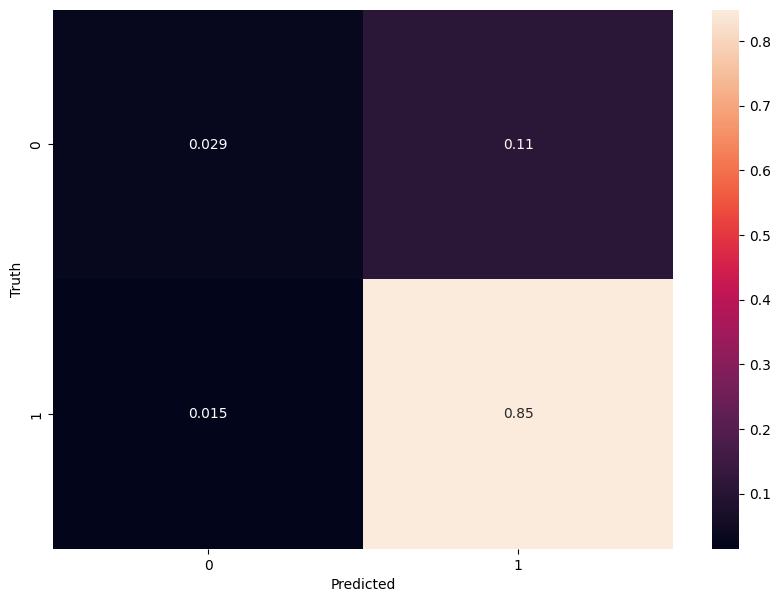

+----------------------------------------+
| Intention model (local_context + bbox) |
+-------------------+--------------------+
|        Acc        |         F1         |
+-------------------+--------------------+
| 0.876980198019802 | 0.9324024119327199 |
+-------------------+--------------------+


In [82]:
# @title Train_Test

def train_intent():
    data_opts = {'fstride': 1,
            'sample_type': 'all',
            'height_rng': [0, float('inf')],
            'squarify_ratio': 0,
            'data_split_type': 'default',
            'seq_type': 'intention', #  crossing , intention
            'min_track_size': 0, #  discard tracks that are shorter
            'max_size_observe': 15,  # number of observation frames
            'max_size_predict': 5,  # number of prediction frames
            'seq_overlap_rate': 0.5,  # how much consecutive sequences overlap
            'balance': False,  # balance the training and testing samples
            'crop_type': 'context',  # crop 2x size of bbox around the pedestrian
            'crop_mode': 'pad_resize',  # pad with 0s and resize to VGG input
            'encoder_input_type': [],
            'decoder_input_type': ['bbox'],
            'output_type': ['intention_binary']}

    t = PIEIntent(num_hidden_units=128,
                  regularizer_val=0.001,
                  lstm_dropout=0.25,
                  lstm_recurrent_dropout=0.2,
                  convlstm_num_filters=64,
                  convlstm_kernel_size=2)
    saved_files_path = ''
    pretrained_model_path = '/content/drive/My Drive/Colab Notebooks/CV/PIE_data/data/pie/intention/context_loc_pretrained'
        #beh_seq_train = imdb.balance_samples_count(beh_seq_train, label_type='intention_binary')
    saved_files_path = t.train(data_train=train,
                                   data_val=val,
                                   epochs=100,
                                   loss=['binary_crossentropy'],
                                   metrics=['accuracy'],
                                   batch_size=32,
                                   optimizer_type='rmsprop',
                                   data_opts=data_opts)
    print(data_opts['seq_overlap_rate'])
    if saved_files_path == '':
            saved_files_path = pretrained_model_path
    acc, f1 = t.test_chunk(test, data_opts, saved_files_path, True)
    t = PrettyTable(['Acc', 'F1'])
    t.title = 'Intention model (local_context + bbox)'
    t.add_row([acc, f1])
    print(t)
    K.clear_session()
    return saved_files_path

intent_model_path = train_intent()

In [83]:
# @title save results in .txt
with open('/content/data/pie/intention/16May2024-07h59m59s/ped_intents.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.keys())
def ndarray_to_list(data):
    if isinstance(data, np.ndarray):
        return data.tolist()
    elif isinstance(data, dict):
        return {k: ndarray_to_list(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [ndarray_to_list(x) for x in data]
    else:
        return data
data = ndarray_to_list(data)
data_str = json.dumps(data)
with open('res.txt', 'w') as f:
    f.write(data_str)


dict_keys(['ped_id', 'images', 'results', 'gt'])
